In [66]:
import models
import data
import cache
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

sns.set(context='paper')

## load files for all cell types

In [23]:
df = cache.cached(data.prep_annotated_data)

In [24]:
assert all(pd.notnull(df['log1p_tpm_rescaled']))

## prep data for a sample of genes

In [26]:
sample_df = models.prep_sample_df(df, sample_n=500)

## fit4: model at level of cell-type, without correlation matrix

In [28]:
stan_data = models.prep_stan_data(sample_df)

In [53]:
stan_file4 = models.get_model_file('model4')
print(cache._read_file(stan_file4))

## try neg binom parameterization
data {
    // dimensions
    int<lower=1> N;  // N obs
    int<lower=1> G;  // N genes
    int<lower=1> S;  // N samples
    int<lower=0> C;  // N classes (e.g. B-cell, T-cell, B_Naive, CD5, CD45RO, etc)
                     // note: classes should be mutually exclusive. Each row here should sum to 1
   
    // data
    int<lower=1, upper=G> gene[N];    // gene id for each obs
    int<lower=1, upper=S> sample[N];  // sample id for each obs
    vector<lower=0, upper=1>[C] x[N]; // map each obs to each class (0:'- or ?', 1:'+')
    int<lower=0> y[N];                // count/tpm for each obs
}
transformed data {
    int sample_y[S, G]; // array (size SxG) of ints
    vector[C] sample_x[S]; // array (size S) of vectors[C]
    for (n in 1:N) {
        sample_y[sample[n], gene[n]] = y[n];
        sample_x[sample[n]] = x[n,];
    }
}
parameters {
    matrix<lower=0>[G, C] theta; // loading factors for each gene, for each cell type
    vector[G] log_gene_base;

In [52]:
fit4 = cache.cached_stan_fit(model_name='model4', file=stan_file4, data=stan_data, iter=500, chains=4)

INFO:cache:Get compiled model code, possibly from cache
INFO:cache:Loading result from cache
INFO:cache:Get posterior draws from model, possibly from cache
INFO:cache:Starting execution of function: sampling
INFO:cache:Saving results to cache


## fit4: superficial check of convergence

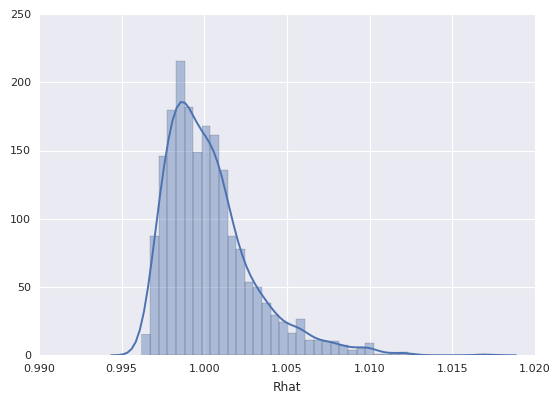

In [55]:
models.plot_stan_summary(fit4, pars='theta', metric='Rhat')

In [56]:
models.print_stan_summary(fit4, pars='lp__')

              mean   se_mean         sd          2.5%           50%         97.5%      Rhat
lp__  6.426773e+07  1.970064  37.534759  6.426765e+07  6.426772e+07  6.426780e+07  1.004146


## fit4: expression factors by gene & cell type

In [57]:
colnames = list(stan_data['x'].columns)

In [58]:
sort_by = colnames[0]
print(sort_by)

cell_type[B]


In [59]:
theta_ldf = models.prep_theta_summary(fit4,
                                    colnames=colnames,
                                    sample_df=sample_df,
                                    expose_group=sort_by)

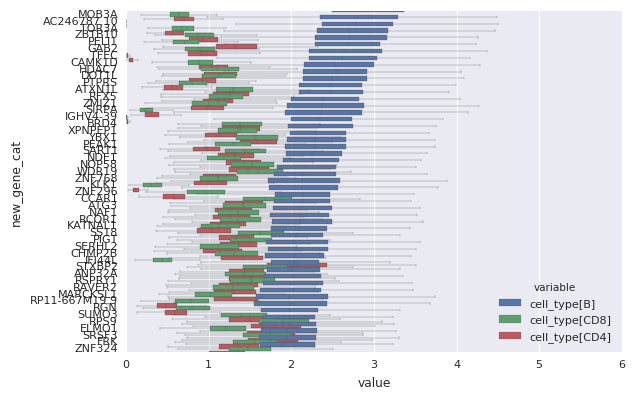

In [60]:
g = sns.boxplot(data=theta_ldf.loc[theta_ldf['mean_value_rank_{}'.format(sort_by)] <= 50,:] \
                .sort_values('mean_value_rank_{}'.format(sort_by)),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, width=2, linewidth=0.2)

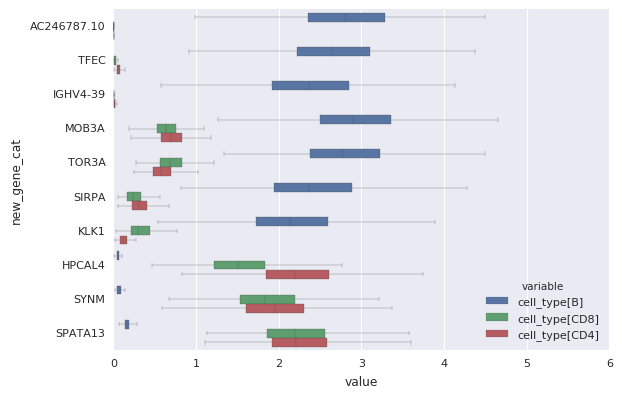

In [61]:
g = sns.boxplot(data=theta_ldf.loc[theta_ldf['mean_abs_diff_rank_{}'.format(sort_by)] <= 10,:] \
                .sort_values('mean_diff_rank_{}'.format(sort_by)),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, linewidth=0.2)

## fit4: review posterior predictions for sample genes

In [63]:
yrep_df = models.prep_yrep_summary(fit4, sample_df=sample_df, sample_kwds=dict(frac=0.5))

In [64]:
top_genes = theta_ldf.loc[theta_ldf['mean_abs_diff_rank_{}'.format(sort_by)] <= 10,:] \
                .drop_duplicates(subset='new_gene_cat')['new_gene_cat'].values

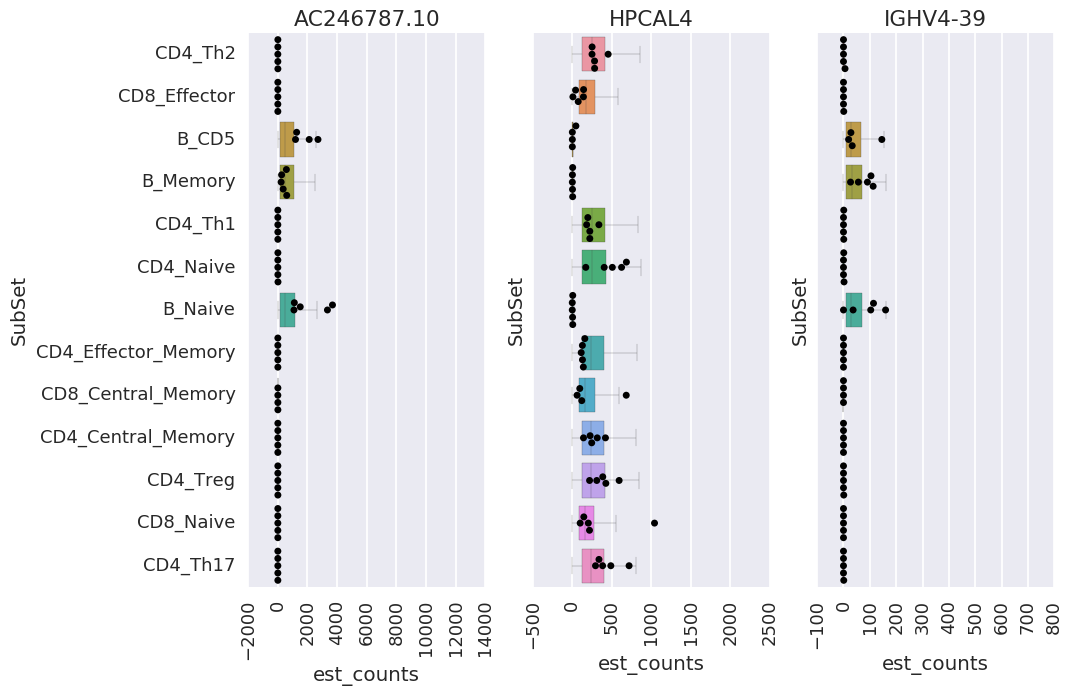

In [97]:
with sns.plotting_context('talk'):
    f, axarr = plt.subplots(1, 3, sharey=True)
    a=0
    for gene_name in top_genes[0:3]:
        g = sns.boxplot(data=yrep_df.loc[yrep_df['gene_cat'] == gene_name, :],
                    y='SubSet',
                    x='pp_est_counts',
                    ax=axarr[a],
                    fliersize=0, linewidth=0.2)
        sns.swarmplot(data=sample_df.loc[sample_df['gene_cat'] == gene_name, :],
                   y='SubSet', ax=axarr[a],
                   x='est_counts', color='black')
        plt.setp(axarr[a].get_xticklabels(), rotation='vertical')
        axarr[a].set_title(gene_name)
        a = a+1


## fit5 - model including estimated correlation matrix

In [99]:
stan_file5 = models.get_model_file('model5')
print(cache._read_file(stan_file5))

## neg binom parameterization
## estimate correlation matrix among cell types
data {
    // dimensions
    int<lower=1> N;  // N obs
    int<lower=1> G;  // N genes
    int<lower=1> S;  // N samples
    int<lower=0> C;  // N classes (e.g. B-cell, T-cell, B_Naive, CD5, CD45RO, etc)
                     //     note: classes should be mutually exclusive. Each row here should sum to 1
    // int<lower=0> M; // number of cell-level predictors 
   
    // data for each gene*sample
    int<lower=1, upper=G> gene[N];    // gene id for each obs
    int<lower=1, upper=S> sample[N];  // sample id for each obs
    vector<lower=0, upper=1>[C] x[N]; // map each obs to each class (0:'- or ?', 1:'+')
    int<lower=0> y[N];                // count/tpm for each obs
    
    // group-level predictors for each class C
    // (to come) - 
}
transformed data {
    int sample_y[S, G];    // array (size SxG) of ints
    vector[C] sample_x[S]; // array (size S) of vectors[C]
    for (n in 1:N) {
        sample

In [106]:
fit5 = models.cached_stan_fit(model_name='model5', file=stan_file5, data=stan_data, iter=500, chains=4)

INFO:cache:Step 1: Get compiled model code, possibly from cache
INFO:cache:StanModel: Loading result from cache
INFO:cache:Step 2: Get posterior draws from model, possibly from cache
INFO:cache:sampling: Loading result from cache


In [107]:
models.print_stan_summary(fit5, pars='theta')

                   mean   se_mean         sd       2.5%        50%      97.5%      Rhat
theta[0,0]    10.590661  0.357159   5.714537   2.356551   9.579294  24.451797  1.002950
theta[1,0]    26.623627  1.571642   9.028396  12.029614  25.496086  46.115552  1.077097
theta[2,0]    14.628352  0.575736   7.681271   3.212083  13.564528  32.674906  1.028654
theta[3,0]    18.971336  0.924905   8.426282   5.526353  17.731044  38.173959  1.028483
theta[4,0]    22.456432  0.617447   8.555591   8.988112  21.614843  40.693699  1.032321
theta[5,0]     4.776584  0.314881   5.597442   0.287609   2.560877  21.180337  1.022271
theta[6,0]     7.252343  0.425601   5.400269   1.145599   5.814218  21.232350  1.026416
theta[7,0]     5.964017  0.293166   4.248381   0.896329   5.135867  16.504096  1.017359
theta[8,0]     3.444597  0.155063   3.539386   0.183144   2.202323  13.521766  1.002133
theta[9,0]     6.882081  0.485780   6.333798   0.478064   5.138304  24.033799  1.014615
theta[10,0]    3.639910  0.16415

## fit5: review posterior estimates of theta_mu

In [108]:
mu_ex = fit5.extract('theta_mu')['theta_mu']

In [109]:
mu_df = pd.DataFrame(mu_ex, columns=list(stan_data['x'].columns))
mu_df.reset_index(inplace=True)
mu_df.rename(columns = {'index': 'iter'}, inplace=True)

In [110]:
mu_ldf = pd.melt(mu_df, id_vars='iter', value_vars=list(stan_data['x'].columns))
mu_ldf.head()

,iter,variable,value
0,0,cell_type[B],7.903178
1,1,cell_type[B],7.831184
2,2,cell_type[B],8.495904
3,3,cell_type[B],9.313664
4,4,cell_type[B],8.095160


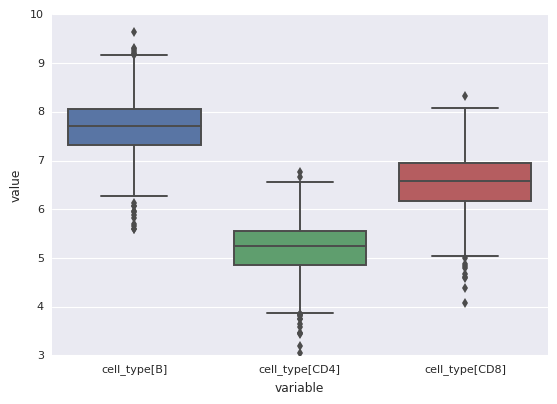

In [111]:
sns.boxplot(data=mu_ldf, x='variable', y='value')

## fit5: review posterior estimates of Omega

In [113]:
omega_df = models.extract_theta_summary(stan_fit=fit5,
                                      colnames=list(stan_data['x'].columns),
                                      gene_id='cell_type',
                                      par='Omega')
omega_df['cell_type'] = omega_df['cell_type'].apply(lambda x: list(stan_data['x'].columns)[x-1])

INFO:cache:prep_annotated_data: Loading result from cache


In [114]:
omega_df.head()

,iter,cell_type[B],cell_type[CD4],cell_type[CD8],cell_type
0,0,1.0,0.905321,0.899304,cell_type[B]
1,1,1.0,0.874804,0.862743,cell_type[B]
2,2,1.0,0.899472,0.892410,cell_type[B]
3,3,1.0,0.843172,0.831093,cell_type[B]
4,4,1.0,0.847535,0.838177,cell_type[B]


In [115]:
omega_summary = omega_df.groupby('cell_type').apply(lambda x: np.mean(x))
print(omega_summary)

                 iter  cell_type[B]  cell_type[CD4]  cell_type[CD8]
cell_type                                                          
cell_type[B]    499.5      1.000000        0.895815        0.887244
cell_type[CD4]  499.5      0.895815        1.000000        0.999372
cell_type[CD8]  499.5      0.887244        0.999372        1.000000


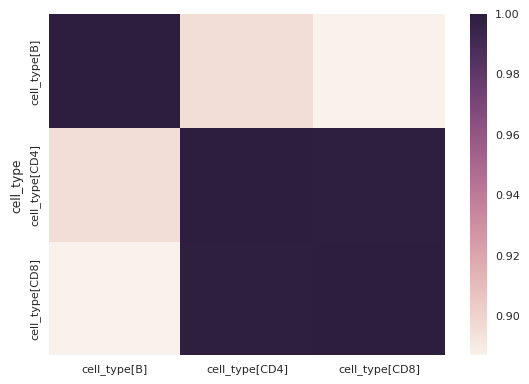

In [116]:
with sns.plotting_context('paper'):
    sns.heatmap(omega_summary.loc[:, list(stan_data['x'].columns)])

## fit5: review posterior estimates of tau

In [117]:
tau_ex = fit5.extract('tau')['tau']

In [118]:
tau_ex.shape

(1000, 3)

In [119]:
tau_df = pd.DataFrame(tau_ex, columns=list(stan_data['x'].columns))
tau_df.reset_index(inplace=True)
tau_df.rename(columns={'index': 'iter'}, inplace=True)
tau_ldf = pd.melt(tau_df, id_vars='iter', value_vars=list(stan_data['x'].columns))

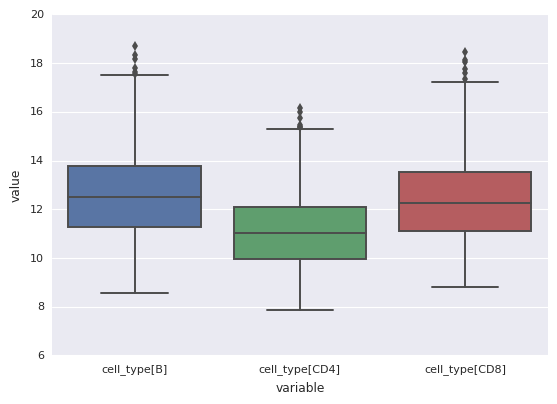

In [120]:
sns.boxplot(data=tau_ldf, x='variable', y='value')

## compare loo output with & without correlation matrix

In [ ]:
loo4 = stanity.psisloo(fit4.extract('log_lik')['log_lik'])
loo5 = stanity.psisloo(fit5.extract('log_lik')['log_lik'])

In [121]:
stanity.loo_compare(loo4, loo5)

/home/jacquelineburos/projects/immune-infiltrate-explorations/.env/lib/python3.5/site-packages/stanity/psis.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sort == 'in-place':
/home/jacquelineburos/projects/immune-infiltrate-explorations/.env/lib/python3.5/site-packages/stanity/psis.py:246: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bs /= 3 * x[sort[np.floor(n/4 + 0.5) - 1]]


{'diff': 26.225231183100547, 'se_diff': 23.546683962886512}